# Salary Predictions Based on Job Descriptions

# Part 1 - DEFINE

### ---- 1 Define the problem ----

As a data scientist, we need to examine the job postings with salaries and predict the salaries for new postings.

In [97]:
#import your libraries
import pandas as pd
import sklearn as sk
import seaborn as sns
import matplotlib.pyplot as plt
#etc

#your info here
__author__ = "Nikhil Gharge"
__email__ = "nikhilgharge93@gmail.com"

## Part 2 - DISCOVER

### ---- 2 Load the data ----

In [32]:
#load the data into a Pandas dataframe
def load_dataset():
    trainData_features_df = pd.read_csv("/Users/nikhilgharge93gmail.com/Desktop/Data Science Dream Job/Instructions_and_Notebook/salaryPredictionPortfolio/Data/train_features.csv")
    trainData_target_df = pd.read_csv("/Users/nikhilgharge93gmail.com/Desktop/Data Science Dream Job/Instructions_and_Notebook/salaryPredictionPortfolio/Data/train_salaries.csv")
    testData_features_df = pd.read_csv("/Users/nikhilgharge93gmail.com/Desktop/Data Science Dream Job/Instructions_and_Notebook/salaryPredictionPortfolio/Data/test_features.csv")
    return trainData_features_df, trainData_target_df, testData_features_df

In [33]:
trainData_features_df, trainData_target_df, testData_features_df = load_dataset()

In [12]:
# This file contains features of different employees
trainData_features_df.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16


In [13]:
# This file contains the salary of respective employees with their jobId
trainData_target_df.head()

,jobId,salary
0,JOB1362684407687,130
1,JOB1362684407688,101
2,JOB1362684407689,137
3,JOB1362684407690,142
4,JOB1362684407691,163


In [14]:
# We need to predict the salaries for the employees in this test data.
testData_features_df.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,JOB1362685407687,COMP33,MANAGER,HIGH_SCHOOL,NONE,HEALTH,22,73
1,JOB1362685407688,COMP13,JUNIOR,NONE,NONE,AUTO,20,47
2,JOB1362685407689,COMP10,CTO,MASTERS,BIOLOGY,HEALTH,17,9
3,JOB1362685407690,COMP21,MANAGER,HIGH_SCHOOL,NONE,OIL,14,96
4,JOB1362685407691,COMP36,JUNIOR,DOCTORAL,BIOLOGY,OIL,10,44


### ---- 3 Clean the data ----

In [39]:
#look for duplicate data, invalid data (e.g. salaries <=0), or corrupt data and remove it
def duplicate_data():
    duplicate_train_features = trainData_features_df.duplicated().sum()
    duplicate_train_target=trainData_target_df.duplicated().sum()
    duplicate_test_features=testData_features_df.duplicated().sum()
    return duplicate_test_features, duplicate_train_features,duplicate_train_target

In [40]:
duplicate_test_features, duplicate_train_features,duplicate_train_target = duplicate_data()

In [41]:
print(duplicate_test_features, duplicate_train_features,duplicate_train_target)

0 0 0


As we can see there are no duplicates present in the above three files.

In [86]:
# Create a final dataset by merging trainData_features_df and trainData_target_df
def merge_Datasets():
    salaryPred_Train_data = pd.merge(trainData_features_df,trainData_target_df,how='inner',on='jobId')
    return salaryPred_Train_data

In [87]:
salaryPred_Train_data = merge_Datasets()

In [88]:
salaryPred_Train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000000 entries, 0 to 999999
Data columns (total 9 columns):
jobId                  1000000 non-null object
companyId              1000000 non-null object
jobType                1000000 non-null object
degree                 1000000 non-null object
major                  1000000 non-null object
industry               1000000 non-null object
yearsExperience        1000000 non-null int64
milesFromMetropolis    1000000 non-null int64
salary                 1000000 non-null int64
dtypes: int64(3), object(6)
memory usage: 76.3+ MB


In [89]:
salaryPred_Train_data.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,130
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,142
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,163


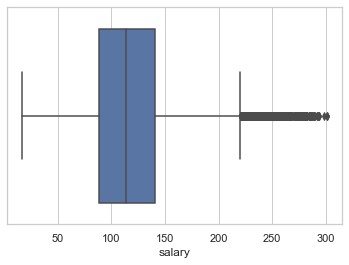

In [95]:
# boxplot for salary columns.
sns.set(style="whitegrid")
ax = sns.boxplot(x=salaryPred_Train_data["salary"])

As it clearly depicts, most of the outliers are in the right most whiskers. 
Finally we will conisder only those values which have salary > 0 in the final dataset

In [91]:
# Boxplot Analysis
info_salaryPredDataset = salaryPred_Train_data.salary.describe()
print(info_salaryPredDataset)
IQR = info_salaryPredDataset['75%'] - info_salaryPredDataset["25%"]
upper = info_salaryPredDataset['75%'] + 1.5 * IQR
lower = info_salaryPredDataset['25%'] - 1.5 * IQR
print("The upper and lower bounds for suspected outliers are {} and {}.".format(upper, lower))

count    1000000.000000
mean         116.061818
std           38.717936
min            0.000000
25%           88.000000
50%          114.000000
75%          141.000000
max          301.000000
Name: salary, dtype: float64
The upper and lower bounds for suspected outliers are 220.5 and 8.5.


In [92]:
# Considering values related to respective upper and lower bounds
salaryPred_Train_data[salaryPred_Train_data['salary'] < lower]

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
30559,JOB1362684438246,COMP44,JUNIOR,DOCTORAL,MATH,AUTO,11,7,0
495984,JOB1362684903671,COMP34,JUNIOR,NONE,NONE,OIL,1,25,0
652076,JOB1362685059763,COMP25,CTO,HIGH_SCHOOL,NONE,AUTO,6,60,0
816129,JOB1362685223816,COMP42,MANAGER,DOCTORAL,ENGINEERING,FINANCE,18,6,0
828156,JOB1362685235843,COMP40,VICE_PRESIDENT,MASTERS,ENGINEERING,WEB,3,29,0


In [93]:
salaryPred_Train_data.loc[salaryPred_Train_data['salary'] > upper, 'jobType'].value_counts()

CEO               3227
CFO               1496
CTO               1488
VICE_PRESIDENT     603
MANAGER            217
SENIOR              66
JUNIOR              20
Name: jobType, dtype: int64

In [99]:
# remove salary below 0
salaryPred_Train_data = salaryPred_Train_data[salaryPred_Train_data['salary'] > lower]
salaryPred_Train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 999995 entries, 0 to 999999
Data columns (total 9 columns):
jobId                  999995 non-null object
companyId              999995 non-null object
jobType                999995 non-null object
degree                 999995 non-null object
major                  999995 non-null object
industry               999995 non-null object
yearsExperience        999995 non-null int64
milesFromMetropolis    999995 non-null int64
salary                 999995 non-null int64
dtypes: int64(3), object(6)
memory usage: 76.3+ MB


### ---- 4 Explore the data (EDA) ----

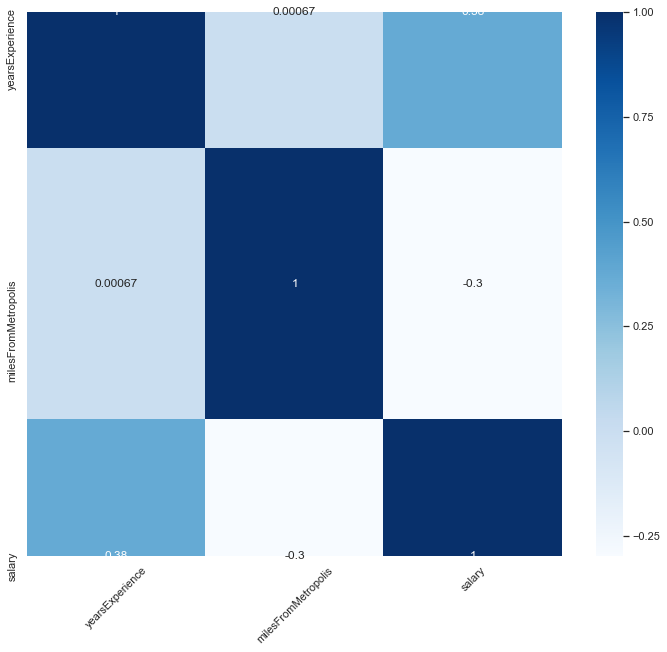

In [98]:
#summarize each feature variable
#summarize the target variable

#look for correlation between each feature and the target
#look for correlation between features
# Correlations between selected features and response
# jobId is discarded because it is unique for individual
fig = plt.figure(figsize=(12,10))
sns.heatmap(salaryPred_Train_data.corr(), cmap = 'Blues', annot = True)
plt.xticks(rotation=45)
plt.show()

### ---- 5 Establish a baseline ----

In [5]:
#select a reasonable metric (MSE in this case)
#create an extremely simple model and measure its efficacy
#e.g. use "average salary" for each industry as your model and then measure MSE
#during 5-fold cross-validation

### ---- 6 Hypothesize solution ----

In [ ]:
#brainstorm 3 models that you think may improve results over the baseline model based
#on your 

Brainstorm 3 models that you think may improve results over the baseline model based on your EDA and explain why they're reasonable solutions here.

Also write down any new features that you think you should try adding to the model based on your EDA, e.g. interaction variables, summary statistics for each group, etc

## Part 3 - DEVELOP

You will cycle through creating features, tuning models, and training/validing models (steps 7-9) until you've reached your efficacy goal

#### Your metric will be MSE and your goal is:
 - <360 for entry-level data science roles
 - <320 for senior data science roles

### ---- 7 Engineer features  ----

In [ ]:
#make sure that data is ready for modeling
#create any new features needed to potentially enhance model

### ---- 8 Create models ----

In [15]:
#create and tune the models that you brainstormed during part 2

### ---- 9 Test models ----

In [1]:
#do 5-fold cross validation on models and measure MSE

### ---- 10 Select best model  ----

In [ ]:
#select the model with the lowest error as your "prodcuction" model

## Part 4 - DEPLOY

### ---- 11 Automate pipeline ----

In [ ]:
#write script that trains model on entire training set, saves model to disk,
#and scores the "test" dataset

### ---- 12 Deploy solution ----

In [16]:
#save your prediction to a csv file or optionally save them as a table in a SQL database
#additionally, you want to save a visualization and summary of your prediction and feature importances
#these visualizations and summaries will be extremely useful to business stakeholders

### ---- 13 Measure efficacy ----

We'll skip this step since we don't have the outcomes for the test data